# 1. QFT

By definition the QFT is the following unitary operation

## $QFT|x\rangle = \frac{1}{2^{n/2}}\sum\limits_{y=0}^{2^n-1}e^{2\pi i \frac{xy}{2^n}} |y\rangle$

Note that here $xy$ is a usual multiplication. Let's unwrap this expression to understand how it can be implemeted in the real circuit. First let's represent $y$  in binary, i.e. $y=y_1 y_2 \dots y_n$ where $y_j$ are either 0 or 1, so

## $y = \sum\limits_{k=1}^{n} 2^{n-k} y_k$

Thus

## $\frac{1}{2^{n/2}}\sum\limits_{y=0}^{2^n-1}e^{2\pi i \frac{xy}{2^n}} |y\rangle = 
\frac{1}{2^{n/2}}\sum\limits_{y=0}^{2^n-1}e^{2\pi ix \left[ \sum\limits_{k=1}^{n} y_k / 2^k \right]} |y_1 y_2 \dots y_n\rangle = 
\frac{1}{2^{n/2}}\sum\limits_{y=0}^{2^n-1}\prod\limits_{k=1}^{n}e^{2\pi ix y_k / 2^k } |y_1 y_2 \dots y_n\rangle = \\ =
\frac{1}{2^{n/2}}\prod\limits_{k=1}^{n}\left( e^{2\pi ix 0 / 2^k } |0\rangle_k + e^{2\pi ix 1 / 2^k } |1\rangle_k \right)= 
\frac{1}{2^{n/2}}\prod\limits_{k=1}^{n}\left( |0\rangle_k + e^{2\pi ix / 2^k } |1\rangle_k \right)= \\ =
\frac{1}{2^{n/2}} \left( |0\rangle_1 + e^{2\pi ix / 2 } |1\rangle_1  \right) \otimes \left( |0\rangle_2 + e^{2\pi ix / 2^2 } |1\rangle_2  \right) \otimes \dots \otimes
\left( |0\rangle_{n-1} + e^{2\pi ix / 2^{n-1} } |1\rangle_{n-1}  \right) \otimes \left( |0\rangle_n + e^{2\pi ix / 2^n } |1\rangle_n  \right)$

We can see that we can construct such a state using single Q-bit gates

## $H|x_k\rangle = \frac{1}{\sqrt{2}}\left( |0\rangle + (-1)^{x_k}|1\rangle \right) \equiv \frac{1}{\sqrt{2}}\left( |0\rangle + e^{2\pi i x_k / 2}|1\rangle \right)$

This is already almost what we want

But we need a phase before the $|1\rangle_k$ state to be equal to $2\pi i x/2^k$. So we have to perform several additional rotations around the $z$-axis

Let's examine the following state

## $\prod\limits_{j=k+1}^{n} C_j ROT_k H |x\rangle_k$

where $C_j ROT_k$ is the controled rotation of the Q-bit $k$ around the $z$ axis on the angle $2\pi/2^k$ with the control Q-bit $j$. We can explicitly rewrite $C_j ROT_k$ in the following form

## $C_j ROT_k |1\rangle_k = e^{2\pi i x_j/2^k} |1\rangle_k$

Which basically means that we add phase $2\pi x_j/2^k$ if the control Q-bit $x_j=1$. 

Noting again that $x/2^n = \sum\limits_{j=1}^{n} x_j / 2^j$

## $\prod\limits_{j=k+1}^{n} C_j ROT_k H |x\rangle_k = \frac{1}{\sqrt{2}} \left( |0\rangle_k + e^{2\pi i \sum\limits_{j=k}^{n}  x_j / 2^j} |1\rangle_k\right) = \frac{1}{\sqrt{2}} \left( |0\rangle_k + e^{2\pi i x / 2^{(n-k)}} |1\rangle_k\right)$

So we get what we wanted, but the Q-bit numbers should be reversed after all the gates, i.e $k \rightarrow n-k$

### Qiskit implemetation of QFT

In [1]:
from qiskit import QuantumCircuit, execute, Aer
from qiskit.visualization import plot_histogram, plot_bloch_vector
import numpy as np
import numpy.random as rand

backend = Aer.get_backend('qasm_simulator')

In [76]:
def qft(qc, n):
    # Hadamards and rotations
    for i in range(n):
        qb = n - i - 1
        qc.h(qb)
        for j in range(n - i - 1):
            qc.cu1(np.pi/np.power(2, j + 1), qb - j - 1, qb)
        qc.barrier()
    
    # Indecies reversal
    for qb in range(n//2):
        qc.swap(qb, n - qb - 1)

Testing for $n = 3$

In [196]:
n = 3
l = np.power(2, n)
# Generating random initial state
init = (rand.rand(2 * l).astype(np.complex) - 0.5) * 2
init /= np.linalg.norm(init)
init = init.reshape(l, 2)
init[:,1] *= 1j
init = init[:,0] + init[:,1]
init

array([ 0.29778659+0.31456028j, -0.29260183-0.40689664j,
        0.24170058+0.07999684j,  0.25434868+0.01303268j,
       -0.20579063-0.09335472j,  0.36644974+0.24322875j,
        0.0012835 -0.02349121j, -0.19178651-0.38686746j])

In [197]:
# Manually calculating the QFT of the inital state
est = np.arange(l).astype(np.complex)
for i, y in enumerate(est):
    amp = np.zeros_like(init).astype(np.complex)
    for j, x in enumerate(init):
        amp[j] = np.exp(2 * np.pi * 1j * i * j / l) * x
    est[i] = 1 / np.sqrt(l) * np.sum(amp)
est

array([ 0.16666158-0.09185015j, -0.07228749-0.08651548j,
       -0.12768758+0.06222033j,  0.55348299+0.26849674j,
        0.07020508+0.28822162j,  0.35519326+0.54495548j,
        0.02092285+0.0542401j , -0.12422301-0.15005783j])

In [198]:
qc = QuantumCircuit(n, n)
qc.initialize(init, range(n))
qft(qc, n)
qc.measure(range(n), range(n));

In [199]:
shots = 4096
res = execute(qc,backend,shots=shots).result()
res = np.array([[int(key, 2), val/shots] for key, val in res.get_counts().items()])

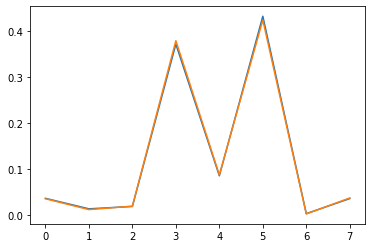

In [200]:
import matplotlib.pyplot as plt
fig,ax=plt.subplots()
ax.plot(res[np.argsort(res[:,0]),1])
ax.plot(np.arange(l),np.abs(est)**2);

The plots coincide, thus our circuit indeed perofrm QFT

Just to double check let's do the same for $n=5$

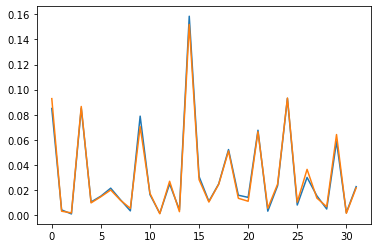

In [195]:
n = 5
l = np.power(2, n)
# Generating random initial state
init = (rand.rand(2 * l).astype(np.complex) - 0.5) * 2
init /= np.linalg.norm(init)
init = init.reshape(l, 2)
init[:,1] *= 1j
init = init[:,0] + init[:,1]

est = np.arange(l).astype(np.complex)
for i, y in enumerate(est):
    amp = np.zeros_like(init).astype(np.complex)
    for j, x in enumerate(init):
        amp[j] = np.exp(2 * np.pi * 1j * i * j / l) * x
    est[i] = 1 / np.sqrt(l) * np.sum(amp)

qc = QuantumCircuit(n, n)
qc.initialize(init, range(n))
qft(qc, n)
qc.measure(range(n), range(n))

shots = 4096
res = execute(qc,backend,shots=shots).result()
res = np.array([[int(key, 2), val/shots] for key, val in res.get_counts().items()])

fig,ax=plt.subplots()
ax.plot(res[np.argsort(res[:,0]),1])
ax.plot(np.arange(l),np.abs(est)**2);

# 2. Quantum phase estimation

We need to estimate a random phase of a single Qbit gate $T=\begin{pmatrix}1 & 0 \\ 0 & e^{i\theta}\end{pmatrix}$

Let's consider the following n + 1 Q-bit state:

$
|\Psi\rangle = H^{\otimes n}|0\rangle \prod \limits_{j=1}^{n} C_jT^j  |1\rangle
$

Where $C_jT^{j}$ is the controled operator $T^j$ with the control Qbit j

So

$|\Psi\rangle = \frac{1}{\sqrt{2^n}}\prod \limits_{j=1}^{n} \left( |0\rangle + e^{ij\theta} |1\rangle \right)|1\rangle$

Let's apply a QFT to the first n Qbits of that state:

## $ |\Psi_F\rangle = \frac{1}{\sqrt{2^n}}\sum\limits_{y=0}^{2^n-1} e^{2\pi i \frac{\Psi y}{2^n}} |y\rangle |\psi\rangle = \frac{1}{2^n}\sum\limits_{j=1}^{n}\sum\limits_{y=0}^{2^n-1} e^{iy\theta} e^{i \frac{2\pi y}{2^n}} |y\rangle |\psi\rangle
$

$H^{\otimes n} |x\rangle = \frac{1}{\sqrt{2^n}} \sum\limits_{z=0}^{2^n-1} e^{i\pi x \cdot z} | z \rangle$

In [194]:
import pandas as pd
eval_phase = []
real_phase = []
for i in range(10):
    n = 5
    phase = 2 * np.pi * rand.rand()
    qc = QuantumCircuit(n + 1, n)

    qc.x(n)
    qc.h(range(n))

    for j in range(n):
        qc.cu1(phase*np.power(2, j), j, n)

    qft(qc, n)
    qc.measure(range(n),range(n))

    res = execute(qc,backend,shots=4096).result()
    res = np.array([[int(key, 2), value] for key, value in res.get_counts().items()])
    eval_phase.append(2 * np.pi * (1 - res[np.argmax(res[:,1]),0] / np.power(2, n) ) )
    real_phase.append(phase)
df = pd.DataFrame(data = {'Real':real_phase,'Evaluated':eval_phase})
df.index.name = 'Exp. №'
df['Abs. error'] = np.abs(df['Real'] - df['Evaluated'])
df['Max. error'] = 2 * np.pi * np.ones_like(df['Real']) / np.power(2, n+1)
df['Correct'] = df['Abs. error'] < df['Max. error']
df

,Real,Evaluated,Abs. error,Max. error,Correct
Exp. №,,,,,
0,2.534077,2.552544,0.018467,0.098175,True
1,6.152035,6.086836,0.065199,0.098175,True
2,5.673657,5.694137,0.020480,0.098175,True
3,1.306778,1.374447,0.067669,0.098175,True
4,5.365013,5.301438,0.063575,0.098175,True
5,3.845263,3.926991,0.081728,0.098175,True
6,4.700933,4.712389,0.011456,0.098175,True
7,5.365336,5.301438,0.063898,0.098175,True
8,1.999906,1.963495,0.036411,0.098175,True


The last columns shows whether the difference between the real and estimated phase is smaller than the expected maximum error of the algorithm $1/2^{n+1}$